In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
import os
from zipfile import ZipFile
import math

In [2]:
from google.colab import files

uploaded = files.upload()              # Downloading the dataset from Kaggle.

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [3]:
!kaggle datasets download -d dasmehdixtr/ddti-thyroid-ultrasound-images #Downloading the dataset from Kaggle.

 99% 17.0M/17.2M [00:01<00:00, 11.4MB/s]
100% 17.2M/17.2M [00:01<00:00, 12.0MB/s]


In [4]:
from zipfile import ZipFile
file_name = "/content/ddti-thyroid-ultrasound-images.zip" 
with ZipFile(file_name,'r') as zip:             # Extracting the data from Zip File.
  zip.extractall("/content/Dataset")
  print('Extracted')

Extracted


In [5]:
from natsort import natsorted

MainDirectory = natsorted(os.listdir("/content/Dataset"))   # Sorting the dataset in the data folder.

XMLlist = []
ImageList = []                          # Initializing the lists to be entirely used later.
TIRADS = []
DataFrame = []

In [6]:
from IPython.core.display import Image
for i in range(len(MainDirectory)):
  if '.xml' in MainDirectory[i]:                          
    XMLlist.append(MainDirectory[i])       # Storing the XML and JPG files from dataset into their lists.
  
  elif '.jpg' in MainDirectory[i]:
    ImageList.append(MainDirectory[i])

ImageList = natsorted(ImageList)     # Sorting both filled lists.
XMLlist = natsorted(XMLlist)


In [7]:
import xml.etree.ElementTree as ET

for i in range(len(XMLlist)):                        
  tree = ET.parse("/content/Dataset" + '/' + XMLlist[i]) 
  root = tree.findall("./tirads")
                                                     # Parsing the XML files to extract the Classes (M/B)
  if root[-1].text!=None:
    Class = [XMLlist[i], root[-1].text]
    TIRADS.append(Class)

TIRADS[:5]

[['2.xml', '2'],
 ['3.xml', '4a'],
 ['4.xml', '4a'],
 ['5.xml', '5'],
 ['6.xml', '4b']]

In [8]:
for i in range(len(TIRADS)):
  XMLDet = TIRADS[i][0][:-4]        
  for j in range(len(ImageList)):
    if XMLDet + '_1.jpg' == ImageList[j] or XMLDet + '_2.jpg' == ImageList[j] or XMLDet + '_3.jpg' == ImageList[j]:
      x = [ImageList[j], TIRADS[i][1]]    
      DataFrame.append(x)                         # Matching the XML file with image files because of
                                                  # repetition and copies/names, And then storing in DF
                                                  # just the image and its respective TIRAD

  Data = pd.DataFrame(DataFrame, columns = ['JPG', 'TIRADS'])

In [9]:
Data.head()

,JPG,TIRADS
0,2_1.jpg,2
1,3_1.jpg,4a
2,4_1.jpg,4a
3,5_1.jpg,5
4,6_1.jpg,4b


In [10]:
img = plt.imread("/content/Dataset/" + Data["JPG"][0])  
print(len(img.shape), img.shape)                              

3 (360, 560, 3)


In [11]:
Data["JPG"][0]
len(Data["JPG"])  
print("/content/Dataset/" + Data["JPG"][0])
len(Data["JPG"])

/content/Dataset/2_1.jpg


347

In [12]:
import cv2

for i in range (0,len(Data["JPG"])):
  image = plt.imread("/content/Dataset/" + Data["JPG"][i])
  image = np.asarray(image)                                # Storing 3 channel image file in variable
                                                           # and converting image to numpy array

  if len(image.shape) > 2:                 #Converting image to 1 channel (Grayscale)
    image = image[:,:,0]
  
  #images.shape





  Filter = (np.ones((5,5), dtype=np.float32))           # Filter for erosion morphological transformation

  ret ,BinarizedImage = cv2.threshold(image ,0 , 255, cv2.THRESH_BINARY)           # Binarizing the image

  BinarizedImage = BinarizedImage.astype(np.uint8)                  # Image as 8-bit single channel image

  MorphOpenedImage = cv2.morphologyEx(BinarizedImage, cv2.MORPH_OPEN, Filter, iterations = 3)
                                                                          # Removing noise in images with
                                                                          # MORPH_OPEN
  ErodedImage = cv2.erode(MorphOpenedImage, Filter, iterations = 5)
                                                                          # eroding the bounderies

  




  contours, hierarchy = cv2.findContours(ErodedImage.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                                                                        # Got list of contours for image
  ContourArea = np.zeros([len(contours)])
  for j in range(len(contours)):       # Getting the Contour Areas for all the contours in the image
    ContourArea[j] = cv2.contourArea(contours[j])

  LargestContour = contours[np.argmax(ContourArea)]  # Finding the index of the largest contour

  x, y, w, h = cv2.boundingRect(LargestContour) 
                                                # Getting the coord. of the largest contour in the image

  if abs(h) > abs(w):
    image2 = np.zeros([h,h])
    image2[:,h-w:h] = image[y:y+h, x:x+w]
    roi = image2

  if abs(w) > abs(h):
    image2 = np.zeros([w,w])
    image2[w-h:w,:] = image[y:y+h, x:x+w]
    roi = image2

  roi = cv2.resize(roi, (190,190), interpolation = cv2.INTER_LANCZOS4) 
                                                                    # Resizing to 190 x 190
  if i == 0:
    images = roi

  else:
    images=np.concatenate((images, roi))

images = np.reshape(images, (len(Data["JPG"]), 190, 190))
images = np.repeat(images[..., np.newaxis], 3, -1)

In [13]:
print(images.shape)
#plt.imshow(images[2,:,:,0])

(347, 190, 190, 3)


In [14]:
t = np.zeros([len(Data["TIRADS"])])

for i in range(len(Data["TIRADS"])):
  if Data["TIRADS"][i]=="2":
    t[i]=0                                    # Creating numerical categories for the TIRADS
  if Data["TIRADS"][i]=="3":                  # and storing as binary class matrices
    t[i]=1
  if Data["TIRADS"][i]=="4a":
    t[i]=2
  if Data["TIRADS"][i]=="4b":
    t[i]=3
  if Data["TIRADS"][i]=="4c":
    t[i]=4
  if Data["TIRADS"][i]=="5":
    t[i]=5

t = tf.keras.utils.to_categorical(t, dtype='float32')

In [15]:
for i in range(len(images)):                               # Normalizing the Images
  images[i,:,:,:] = images[i,:,:,:] * (1/np.max(images[i,:,:,:]))
images = images.astype('float32')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


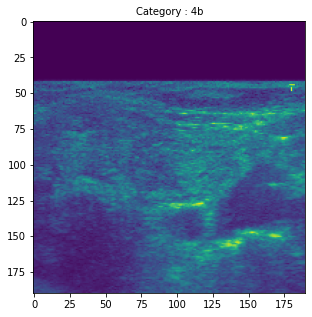

In [16]:
title = "Category : " + np.str(Data["TIRADS"][8])
plt.figure(figsize = (5,5))
plt.title(title,fontsize = 10)
plt.imshow(images[8,:,:,0])

In [17]:
images.shape

(347, 190, 190, 3)

In [18]:
x_train = np.copy(images[:320,:,:,:])
y_train = np.copy(t[:320,:])
                                        # Splitting Training, Testing and Validation sets.
x_valid = np.copy(images[320:323,:,:,:])
y_valid = np.copy(t[320:323,:])

x_test = np.copy(images[323:,:,:,:])
y_test = np.copy(t[323:,:])

In [19]:
# Some Data Augmentation

Augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
              tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.2),fill_mode="constant"),
              tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.2),fill_mode="constant"),
              tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)])    

aug_x_train = Augmentation(x_train)
aug_y_train = np.copy(y_train)


for i in range(22):
  aug_images = Augmentation(images)
  aug_x_train = np.concatenate((aug_x_train, aug_images), axis=0)
  aug_t = np.copy(t)
  aug_y_train = np.concatenate((aug_y_train, aug_t))
  i += 1


In [20]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19

inputshape = [190, 190]

vgg19 = VGG19(input_shape = inputshape + [3], weights = 'imagenet', include_top = False)

80150528/80134624 [==============================] - 0s 0us/step


In [21]:
for layer in vgg19.layers:
  layer.trainable = False


In [22]:
X = Flatten()(vgg19.output)    
prediction = Dense(6, activation='softmax')(X)          # 6 classes
model = Model(inputs=vgg19.input, outputs = prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 190, 190, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 190, 190, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 190, 190, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 95, 95, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 95, 95, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 95, 95, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 47, 47, 128)       0     

In [23]:
from keras import optimizers
import keras.backend as K

def F1_score(y_true, y_pred):                                        #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [24]:
adam = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), F1_score])

In [25]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



checkpoint = ModelCheckpoint(filepath='/content/Bestmodel.h5', 
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit(
  aug_x_train, 
  aug_y_train,
  epochs=40,
  validation_data=(x_valid, y_valid),
  callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.48832, saving model to /content/Bestmodel.h5
249/249 - 55s - loss: 0.4287 - accuracy: 0.3010 - precision: 0.3693 - recall: 0.1103 - F1_score: 0.1585 - val_loss: 0.4883 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_F1_score: 0.0000e+00 - 55s/epoch - 221ms/step
Epoch 2/40

Epoch 2: val_loss improved from 0.48832 to 0.45503, saving model to /content/Bestmodel.h5
249/249 - 34s - loss: 0.3761 - accuracy: 0.4249 - precision: 0.5414 - recall: 0.2244 - F1_score: 0.3129 - val_loss: 0.4550 - val_accuracy: 0.3333 - val_precision: 0.5000 - val_recall: 0.3333 - val_F1_score: 0.4000 - 34s/epoch - 135ms/step
Epoch 3/40

Epoch 3: val_loss did not improve from 0.45503
249/249 - 33s - loss: 0.3486 - accuracy: 0.4857 - precision: 0.6153 - recall: 0.2954 - F1_score: 0.3968 - val_loss: 0.5564 - val_accuracy: 0.3333 - val_precision: 1.0000 - val_recall: 0.3333 - val_F1_score: 0.5000 - 33s/epoch - 133ms/step
Epoch 4/40



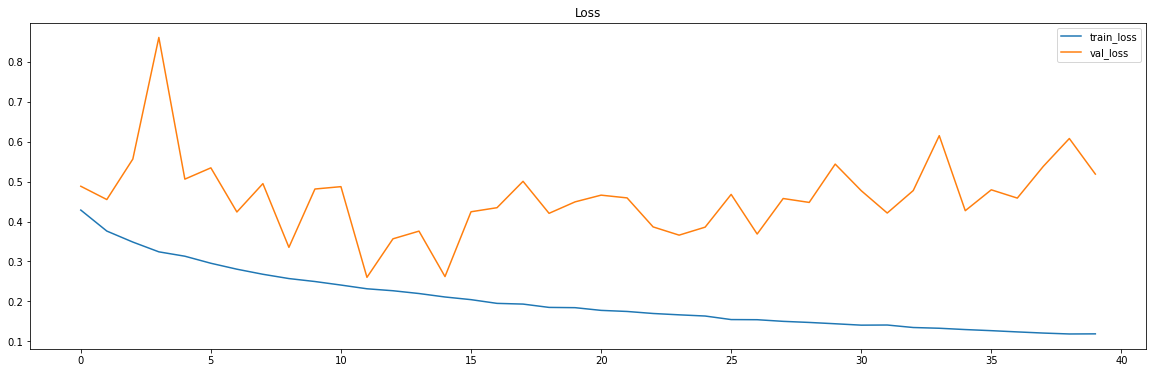

In [26]:
#model.save("my_h5_model.h5")

plt.figure(figsize = (20,6))
plt.title('Loss')                                              # Loss Visualization
plt.plot(model_history.history['loss'], label='train_loss')
plt.plot(model_history.history['val_loss'], label='val_loss')
plt.legend()

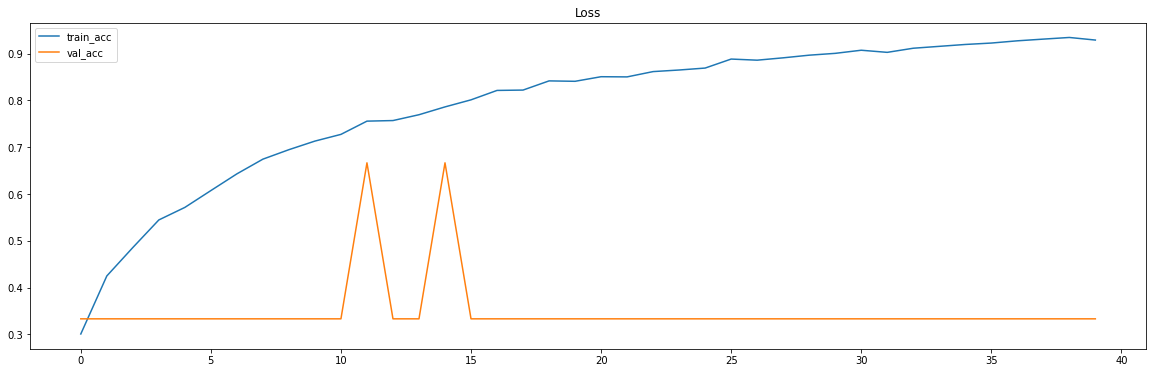

In [27]:
plt.figure(figsize = (20,6))
plt.title('Loss')                                              # Accuracy Visualization
plt.plot(model_history.history['accuracy'], label='train_acc')
plt.plot(model_history.history['val_accuracy'], label='val_acc')
plt.legend()

In [28]:
from keras.models import load_model
model = load_model("/content/Bestmodel.h5" , custom_objects={"F1_score": F1_score })

from sklearn.metrics import roc_auc_score
predict= model.predict(x_test)                 # Model Evaluation
auc = roc_auc_score(y_test, predict)

In [29]:
print(auc)    # AUC score is a vital evaluation metric for Classification problem

0.9276837071107904


In [30]:
pred = model.predict(x_test)

In [45]:
img_array=x_test[20,:,:,:]
actualcat = y_test[20]
img_array = np.reshape(img_array,(1,190,190,3))
preds = model.predict(img_array)

index_max = max(range(len(preds)), key=preds.__getitem__)

for i in range(len(actualcat)):
  if actualcat[i] == 1:
    index = i

if index == 0:
  Classification = 'Benign'
elif index == 1 or index == 2 or index == 3 or index == 4 or index == 5:
  Classification = 'Malignant'


if (index == index_max):
  print("Correct Prediction! Thyroid Nodule is", Classification)
else:
  print("Incorrent Prediction!")

Correct Prediction! Thyroid Nodule is Benign
